In [50]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import ttest_rel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [7]:
from src import utils
from src import validation
from src import base_forecast
from src.utils import print_title

In [8]:
import importlib
importlib.reload(utils)
importlib.reload(validation)
importlib.reload(base_forecast)

<module 'src.base_forecast' from '/Users/jobandtalent/Documents/GitHub/forecast-incremental-workflow/src/base_forecast.py'>

## DATA INGESTION

### LOAD

In [9]:
day_df_raw = pd.read_csv('../data/day.csv')
display(day_df_raw.head())
print('DF Size: ', day_df_raw.shape)
print('DF Types: \n', day_df_raw.dtypes)

df = day_df_raw.copy()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


DF Size:  (731, 16)
DF Types: 
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


### DTYPES

In [10]:
datetime_columns = ['dteday']
float64_columns = ['temp','atemp','hum','windspeed']
str_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
int64_columns = ['casual', 'registered', 'cnt']

# Basic data conversion
df = utils.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)
# Rename columns
df.rename(columns={
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'weathersit':'weather',
    'temp':'temperature',
    'atemp':'temperature_sensation',
    'hum':'humidity',
    'casual':'casual_users',
    'registered':'registered_users',
    'cnt':'bikes_rented'
}, inplace=True)
# Drop not used columns
df.drop(columns=['instant'], inplace=True)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
date                     datetime64[ns]
season                           object
year                             object
month                            object
holiday                          object
weekday                          object
workingday                       object
weather                          object
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      Int64
registered_users                  Int64
bikes_rented                      Int64
dtype: object


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## DATA CLEANING AND QA

### DESCRIBE

In [11]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('DISTRIBUTIONS')
display(df['season'].value_counts().sort_index())
display(df['year'].value_counts().sort_index())
display(df['month'].value_counts().sort_index())
display(df['holiday'].value_counts().sort_index())
display(df['weekday'].value_counts().sort_index())
display(df['workingday'].value_counts().sort_index())
display(df['weather'].value_counts().sort_index())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   731 non-null    datetime64[ns]
 1   season                 731 non-null    object        
 2   year                   731 non-null    object        
 3   month                  731 non-null    object        
 4   holiday                731 non-null    object        
 5   weekday                731 non-null    object        
 6   workingday             731 non-null    object        
 7   weather                731 non-null    object        
 8   temperature            731 non-null    float64       
 9   temperature_sensation  731 non-null    float64       
 10  humidity               731 non-null    float64       
 11  windspeed              731 non-null    float64       
 12  casu

None

----------------------- DF DESCRIBE -----------------------


,date,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
count,731,731.000000,731.000000,731.000000,731.000000,731.0,731.0,731.0
mean,2012-01-01 00:00:00,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
min,2011-01-01 00:00:00,0.059130,0.079070,0.000000,0.022392,2.0,20.0,22.0
25%,2011-07-02 12:00:00,0.337083,0.337842,0.520000,0.134950,315.5,2497.0,3152.0
50%,2012-01-01 00:00:00,0.498333,0.486733,0.626667,0.180975,713.0,3662.0,4548.0
75%,2012-07-01 12:00:00,0.655417,0.608602,0.730209,0.233214,1096.0,4776.5,5956.0
max,2012-12-31 00:00:00,0.861667,0.840896,0.972500,0.507463,3410.0,6946.0,8714.0
std,NaN,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452


---------------------- DISTRIBUTIONS ----------------------


season
1    181
2    184
3    188
4    178
Name: count, dtype: int64

year
0    365
1    366
Name: count, dtype: int64

month
1     62
10    62
11    60
12    62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
Name: count, dtype: int64

holiday
0    710
1     21
Name: count, dtype: int64

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64

workingday
0    231
1    500
Name: count, dtype: int64

weather
1    463
2    247
3     21
Name: count, dtype: int64

### DUPLICATES

In [12]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [13]:

primary_key_column = 'date'

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if primary_key_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(primary_key_column).drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on date column: 0


### NULLS

In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
date                     0
season                   0
year                     0
month                    0
holiday                  0
weekday                  0
workingday               0
weather                  0
temperature              0
temperature_sensation    0
humidity                 0
windspeed                0
casual_users             0
registered_users         0
bikes_rented             0
dtype: int64


### OUTLIERS

In [15]:
target_columns = ['casual_users', 'registered_users', 'bikes_rented']

numeric_cols = df.drop(columns=target_columns, errors='ignore').select_dtypes(include=["number"])
outliers_df = utils.detect_outliers(numeric_cols, method="iqr")
outlier_rows = df.loc[outliers_df.any(axis=1)]
print_title('ANOMALY ROWS')
display(outliers_df[outliers_df['is_outlier']])

df["extreme_weather"] = outliers_df["is_outlier"].astype(int).astype(str)
display(df.head())

----------------------- ANOMALY ROWS -----------------------


,iqr_outlier,zscore_outlier,outlier_columns,is_outlier
44,True,False,[windspeed],True
49,True,False,"[humidity, windspeed]",True
68,True,False,[humidity],True
93,True,False,[windspeed],True
94,True,False,[windspeed],True
292,True,False,[windspeed],True
382,True,False,[windspeed],True
407,True,False,[windspeed],True
420,True,False,[windspeed],True
432,True,False,[windspeed],True


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0


## EDA

In [16]:
target_column = 'bikes_rented'
try:
    df.drop(columns=['registered_users', 'casual_users'], inplace= True)
except:
    pass
display(df.head())

,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


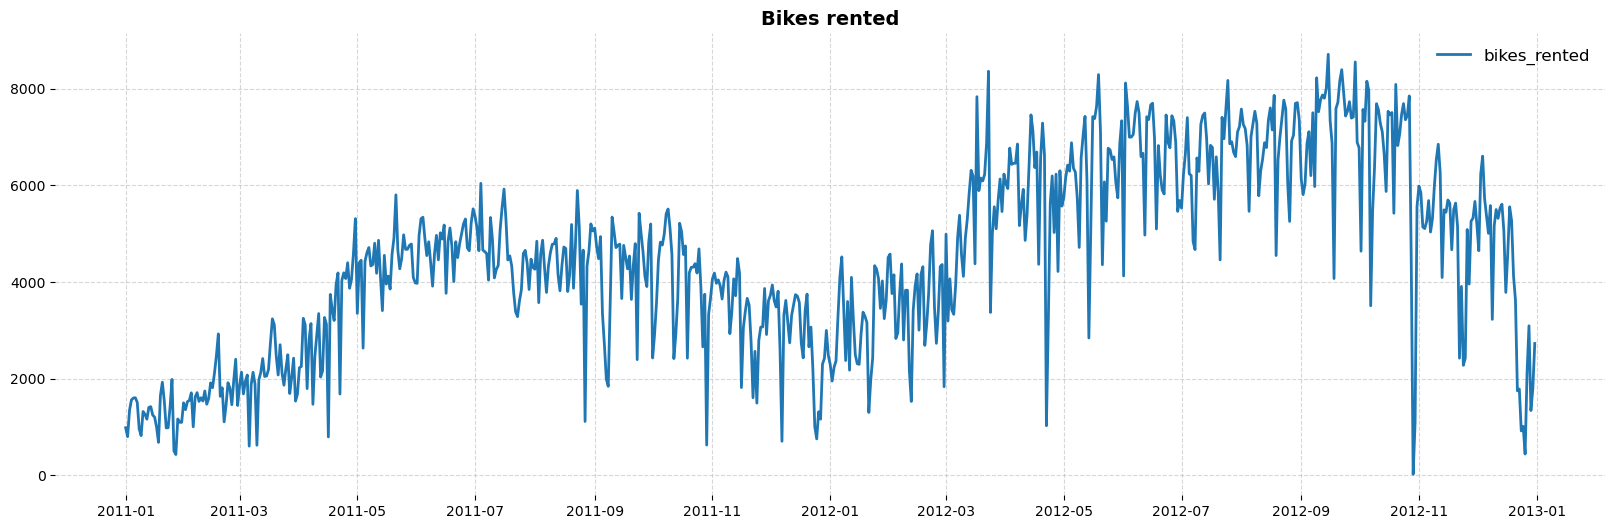

In [17]:
utils.plot_time_series(df, [target_column], 0.9, '--')

### STATIONARITY

In [18]:

stationary_result = adfuller(df["bikes_rented"])
is_stationary_resultt = True if stationary_result[1] < 0.05 else False
print(f"ADF Statistic: {stationary_result[0]}")
print(f"P-value: {stationary_result[1]}")
print("Conclusion:", "Stationary" if stationary_result[1] < 0.05 else "Non-stationary")

ADF Statistic: -1.8774481444374296
P-value: 0.34274344033921944
Conclusion: Non-stationary


### TREND

In [19]:

trend_result = kpss(df["bikes_rented"], regression="c")
is_trend_present = True if trend_result[1] < 0.05 else False
print(f"KPSS Statistic: {trend_result[0]}")
print(f"P-value: {trend_result[1]}")
print("Conclusion:", "Trend present" if trend_result[1] < 0.05 else "No significant trend")

KPSS Statistic: 2.424033427910016
P-value: 0.01
Conclusion: Trend present


### TIME PERSISTENCE AND SEASONALITY

In [20]:
nlags = 365
acf_values = acf(df["bikes_rented"], nlags=nlags, fft=True)

autocorrelated_lags = np.where(np.abs(acf_values) > 0.5)[0]
autocorrelation_ratio = len(autocorrelated_lags) / nlags

seasonal_lags = [lag for lag in autocorrelated_lags if lag % 7 == 0 or lag % 30 == 0 or lag % 365 == 0]

print(f"Lags with autocorrelation: {autocorrelated_lags.tolist()}")
print(f"Percentage of significant lags: {autocorrelation_ratio:.2%}")
print(f"Possible seasonal lags: {seasonal_lags}")

if autocorrelation_ratio > 0.5:
    print("Strong temporal dependence detected.")
elif autocorrelation_ratio > 0.3:
    print("Moderate temporal dependence detected.")
else:
    print("Low temporal dependence.")

if len(seasonal_lags) > 2:
    is_seasonality_present = True
    print("Seasonality detected.")
else:
    is_seasonality_present = False
    print("No clear seasonality.")

Lags with autocorrelation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]
Percentage of significant lags: 13.97%
Possible seasonal lags: [0, 7, 14, 21, 28, 30, 35, 42, 49]
Low temporal dependence.
Seasonality detected.


### ACF AND PACF

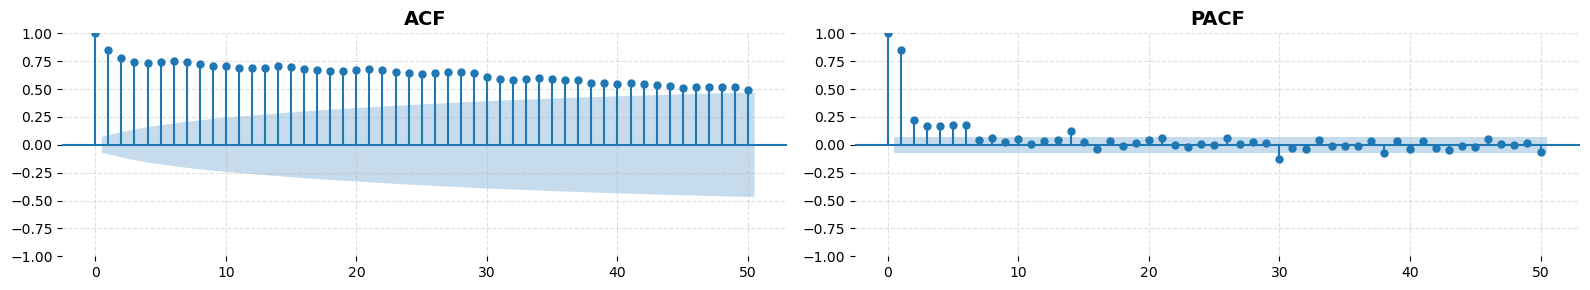

In [21]:
utils.plot_acf_and_pacf(df[target_column])

### DECOMPOSITION

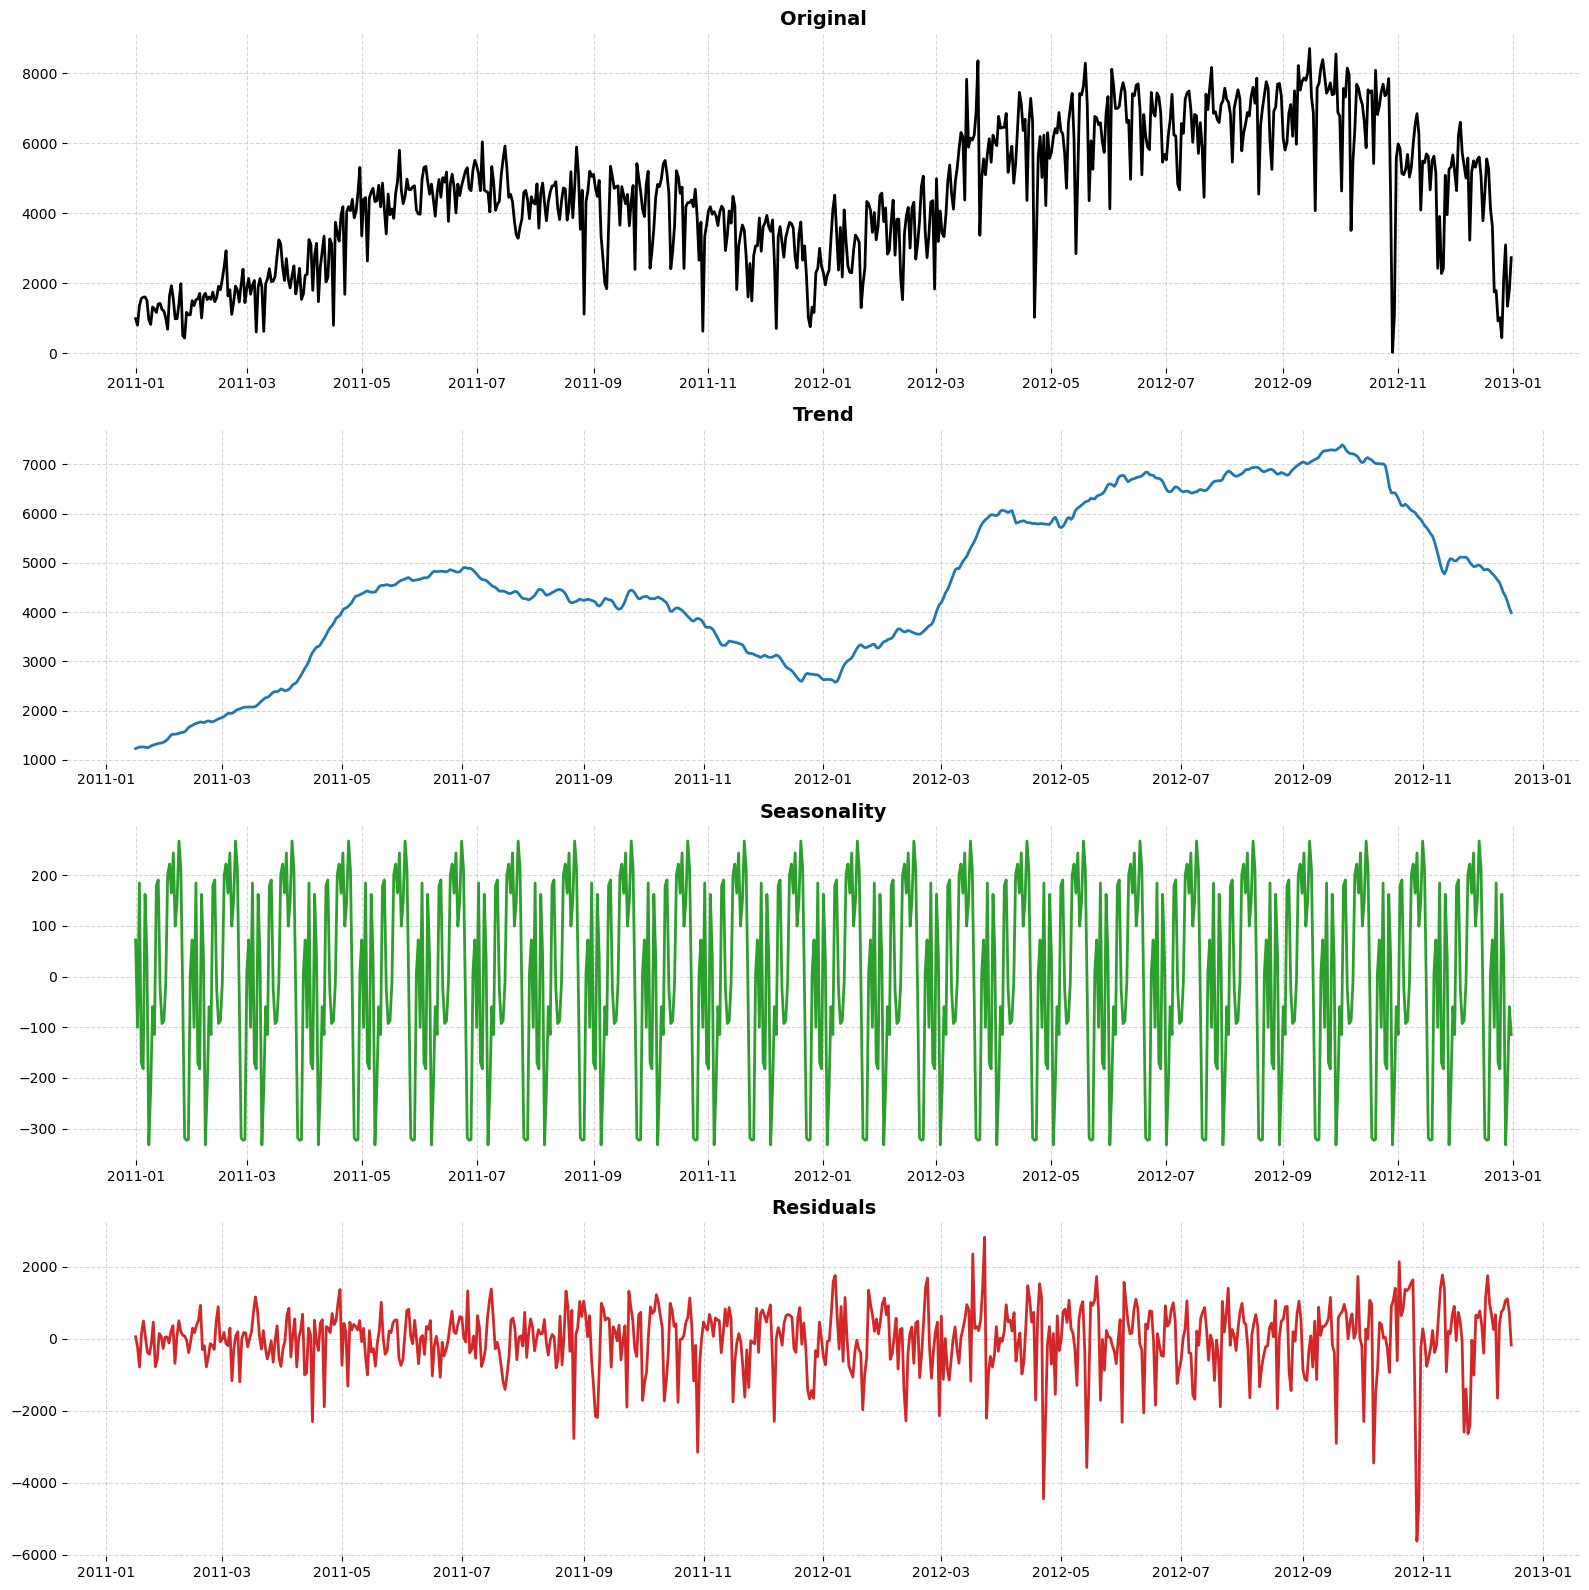

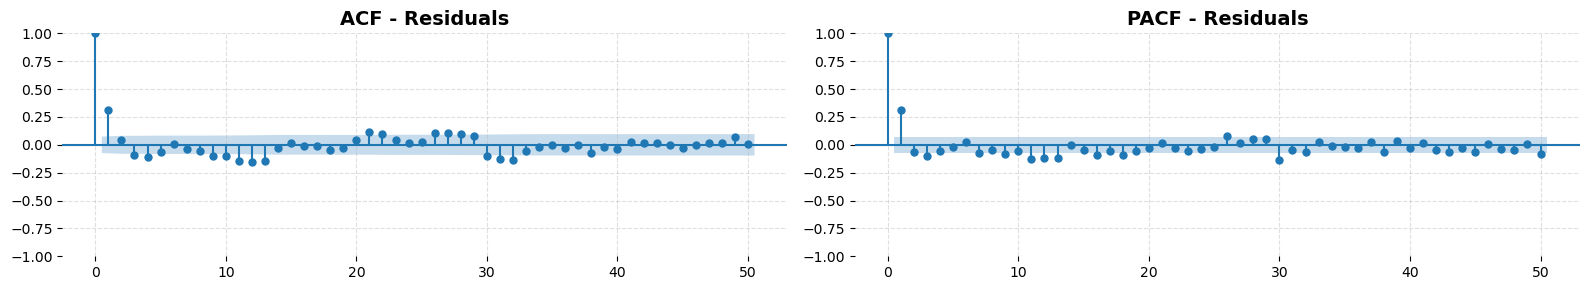

In [22]:
decomposed = seasonal_decompose(df[target_column], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(16, 16))

axes[0].plot(df["date"], decomposed.observed, color="black", linewidth=2)
axes[0].set_title("Original", fontsize=14, fontweight='bold')

axes[1].plot(df["date"], decomposed.trend, color="tab:blue", linewidth=2)
axes[1].set_title("Trend", fontsize=14, fontweight='bold')

axes[2].plot(df["date"], decomposed.seasonal, color="tab:green", linewidth=2)
axes[2].set_title("Seasonality", fontsize=14, fontweight='bold')

axes[3].plot(df["date"], decomposed.resid, color="tab:red", linewidth=2)
axes[3].set_title("Residuals", fontsize=14, fontweight='bold')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='x', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

utils.plot_acf_and_pacf(decomposed.resid.dropna(), ' - Residuals')

### OUTLIERS

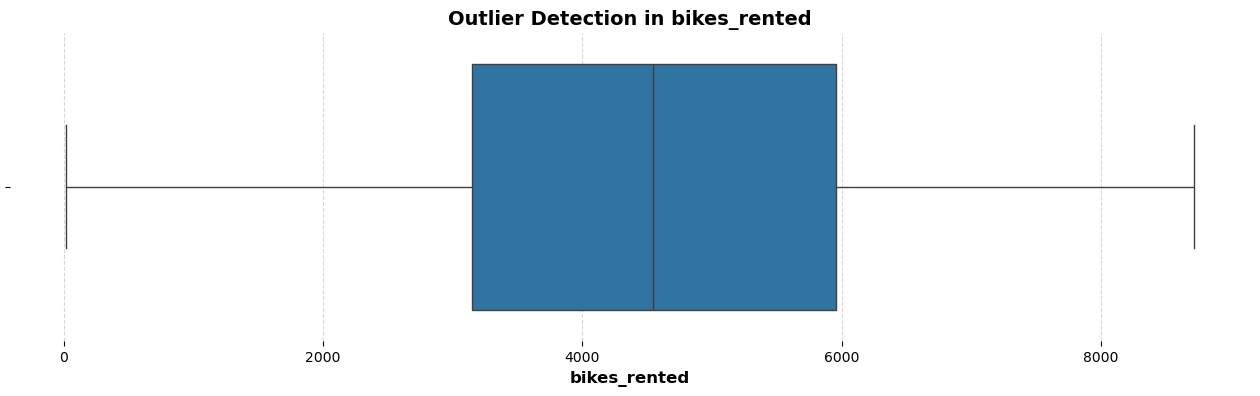

In [23]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(
    x=df[target_column], 
    ax=ax, 
    flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 6}
)

ax.set_title(f"Outlier Detection in {target_column}", fontsize=14, fontweight="bold")
ax.set_xlabel(target_column, fontsize=12, fontweight="bold")

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

### EXOGENS

In [24]:
excluded_columns = ["bikes_rented", "date"]

exogen_columns = [
    col for col in df.columns 
    if col not in excluded_columns and df[col].dtype in ["int64", "float64", "uint8", "object"]
]
print("Exogenous variables for forecasting:", exogen_columns)

Exogenous variables for forecasting: ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weather', 'temperature', 'temperature_sensation', 'humidity', 'windspeed', 'extreme_weather']


### NUMERIC CORRELATION AND COLLINEARITY

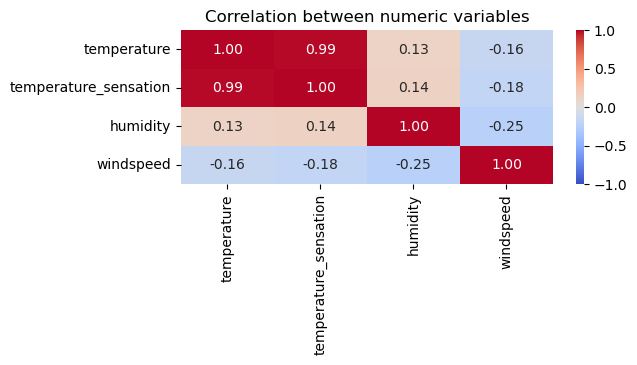

In [25]:
plt.figure(figsize=(6, 2))
numeric_to_corr_df = df.select_dtypes(include=["number"]).drop(columns=[target_column], errors="ignore")
corr_df = numeric_to_corr_df.corr()
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between numeric variables")
plt.show()

In [26]:
X = numeric_to_corr_df.dropna().select_dtypes(include=["number"]).astype("float64")

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

corr_matrix = X.corr().abs()
high_corr_pairs = np.where(corr_matrix > 0.8)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

print("Highly correlated variable pairs:", high_corr_pairs)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print('\n')
print("VIF:")
print(vif_data)

target_corr = df.corr()["bikes_rented"].drop(["bikes_rented", "date"])
print('\n')
print("ABS Correlation values:")
print(abs(target_corr).sort_values(ascending=False))

Highly correlated variable pairs: [('temperature', 'temperature_sensation')]


VIF:
                Variable         VIF
1  temperature_sensation  543.242186
0            temperature  488.553062
2               humidity   11.064126
3              windspeed    4.682492


ABS Correlation values:
temperature_sensation    0.631066
temperature              0.627494
year                     0.566710
season                   0.406100
weather                  0.297391
month                    0.279977
windspeed                0.234545
extreme_weather          0.105338
humidity                 0.100659
holiday                  0.068348
weekday                  0.067443
workingday               0.061156
Name: bikes_rented, dtype: float64


## BASE FORECAST FEATURE ENGINEERING

### FEATURE SELECTION

In [27]:
features_to_remove = set()
for pair in high_corr_pairs:
    feature_to_remove = pair[0] if abs(target_corr[pair[0]]) < abs(target_corr[pair[1]]) else pair[1]
    features_to_remove.add(feature_to_remove)

# Remove high VIF features (threshold >10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Variable"].tolist()
features_to_remove.update(high_vif_features)

# Select relevant features
selected_features = [feature for feature in exogen_columns if feature not in features_to_remove]
selected_features = sorted(selected_features, key=lambda x: abs(target_corr[x]), reverse=True)
print("Final selected exogenous variables:", selected_features)

Final selected exogenous variables: ['year', 'season', 'weather', 'month', 'windspeed', 'extreme_weather', 'holiday', 'weekday', 'workingday']


### TIME NORMALIZATION

In [28]:
use_time_normalization = False
selection_df = df.copy()
target_time_norm_column = target_column + "_time_norm"

if use_time_normalization:
    forecast_column = target_time_norm_column
    selection_df[forecast_column] = df[target_column] / df["date"].dt.days_in_month
    try:
        selection_df.drop(columns=target_column, inplace=True)
    except:
        pass
else:
    forecast_column = target_column
    try:
        selection_df.drop(columns=target_time_norm_column, inplace=True)
    except:
        pass

print('Forecast variable: ', forecast_column)
display(selection_df.head(1))

Forecast variable:  bikes_rented


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0


### TRANSFORMATIONS

In [29]:
selection_df = selection_df[['date'] + selected_features + [forecast_column]]

print_title('Recommended Transformations')
transformations = utils.check_transformations(selection_df)

print('\n')
print_title('DF Prepared')
transformed_df = utils.apply_transformations(selection_df, transformations)
print('Forecast variable: ', forecast_column)

--------------- Recommended Transformations ---------------
             stationary recommended_transformation
windspeed          True                       none
bikes_rented      False                     boxcox


----------------------- DF Prepared -----------------------
Transformations applied successfully.


,date,year,season,weather,month,windspeed,extreme_weather,holiday,weekday,workingday,bikes_rented
0,2011-01-01,0,1,2,1,0.160446,0,0,6,0,499.329506
1,2011-01-02,0,1,2,1,0.248539,0,0,0,0,415.834439
2,2011-01-03,0,1,1,1,0.248309,0,0,1,1,659.495676
3,2011-01-04,0,1,1,1,0.160296,0,0,2,1,750.805907
4,2011-01-05,0,1,1,1,0.186900,0,0,3,1,766.938328


Forecast variable:  bikes_rented


## BASELINE AND VALIDATION

### BASELINE

In [30]:
naive_forecast_df = base_forecast.naive_forecast(transformed_df, forecast_column, steps=60)
baseline_column = 'naive_forecast'

### VALIDATION

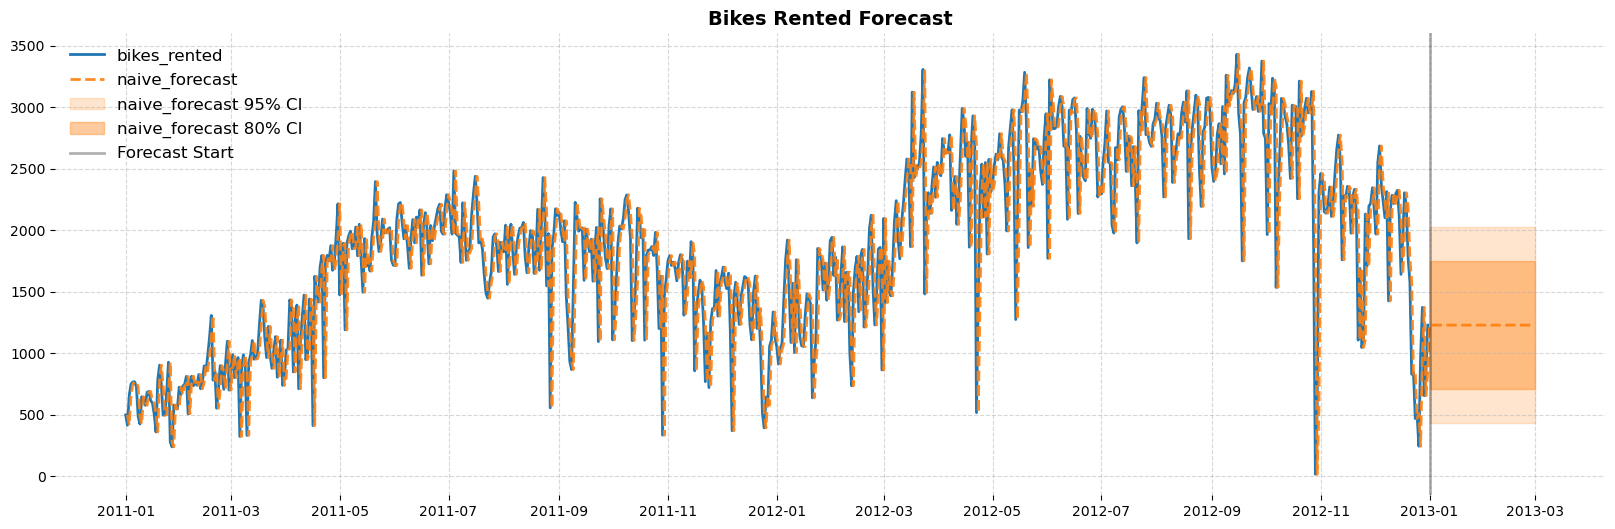

In [31]:
validation.plot_time_series_forecast(naive_forecast_df, [forecast_column, 'naive_forecast'])

#### METRICS

In [32]:
model_metrics = validation.calculate_forecast_metrics(naive_forecast_df, naive_forecast_df, forecast_column, "naive_forecast")
print(model_metrics)

{'MAE': 278.5863254953301, 'RMSE': 407.23722669057526, 'SMAPE': 18.142430243257664, 'MASE': 1.0}


#### TIME VALIDATION

In [33]:
# Walk-Forward Validation
walk_results = validation.walk_forward_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, n_splits=5)

# Expanding Window Validation
expanding_results = validation.expanding_window_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, initial_train_size=100)

# Rolling Window Validation
rolling_results = validation.rolling_window_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, window_size=100)

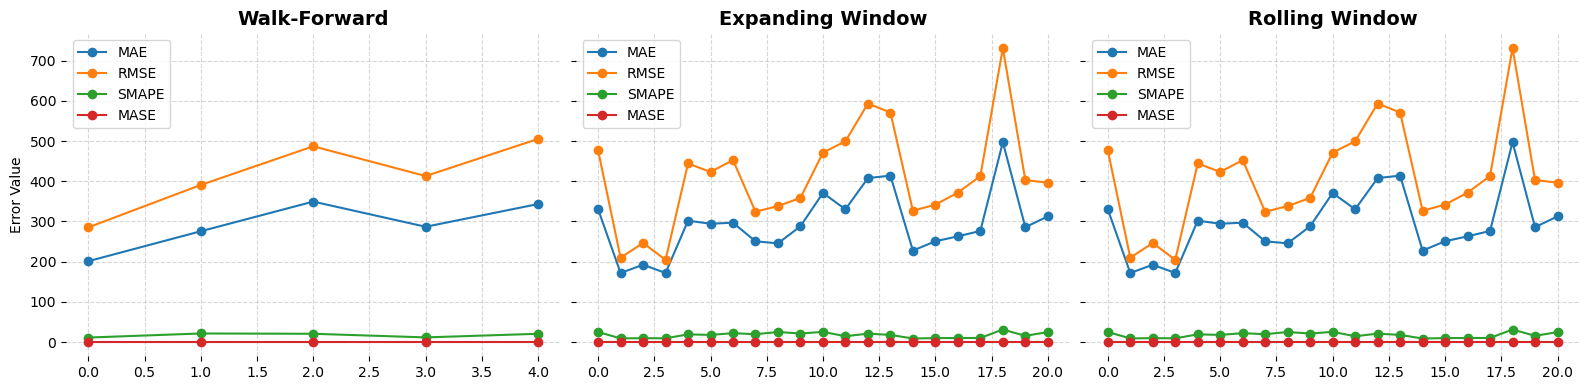

In [34]:
validation.plot_validation_results(walk_results, expanding_results, rolling_results)

#### RESIDUALS

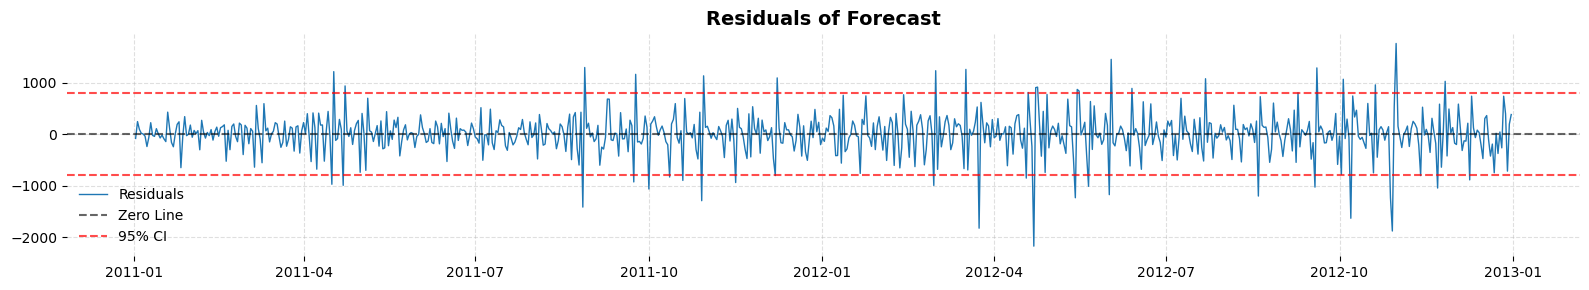

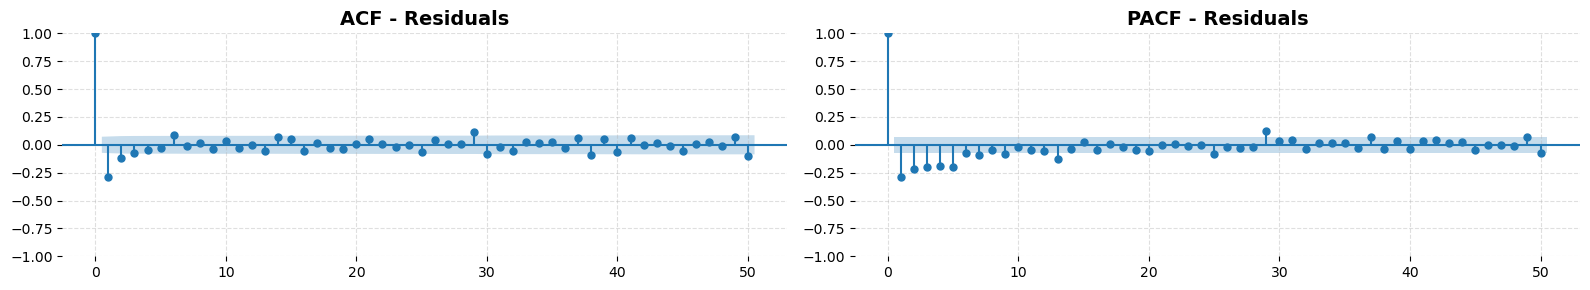

In [35]:
validation.check_forecast_residuals(naive_forecast_df, "bikes_rented", "naive_forecast")


### BASELINE COMPARISON

In [36]:
comparison_results = validation.compare_forecast_models(naive_forecast_df, naive_forecast_df, naive_forecast_df, forecast_column, "naive_forecast")
formatted_results_df = validation.format_comparison_results(comparison_results)
display(formatted_results_df)

,Model,Baseline,Improvement
MAE,278.586325,278.586325,0.0
RMSE,407.237227,407.237227,0.0
SMAPE,18.14243,18.14243,0.0
MASE,1.0,1.0,0.0
DM Test p-value,,,nan
Statistical Significance,,,Not Significant


## UNIVARIANT FORECASTING

### BASE FORECASTING

#### RANDOM WALK

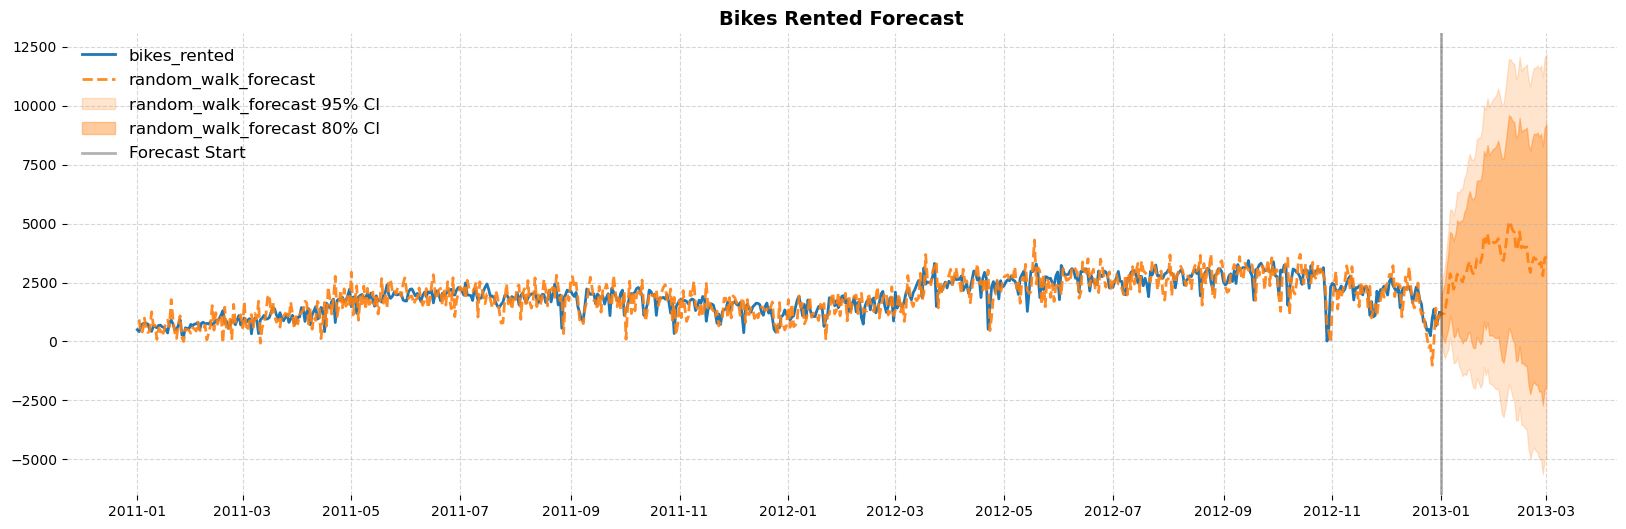

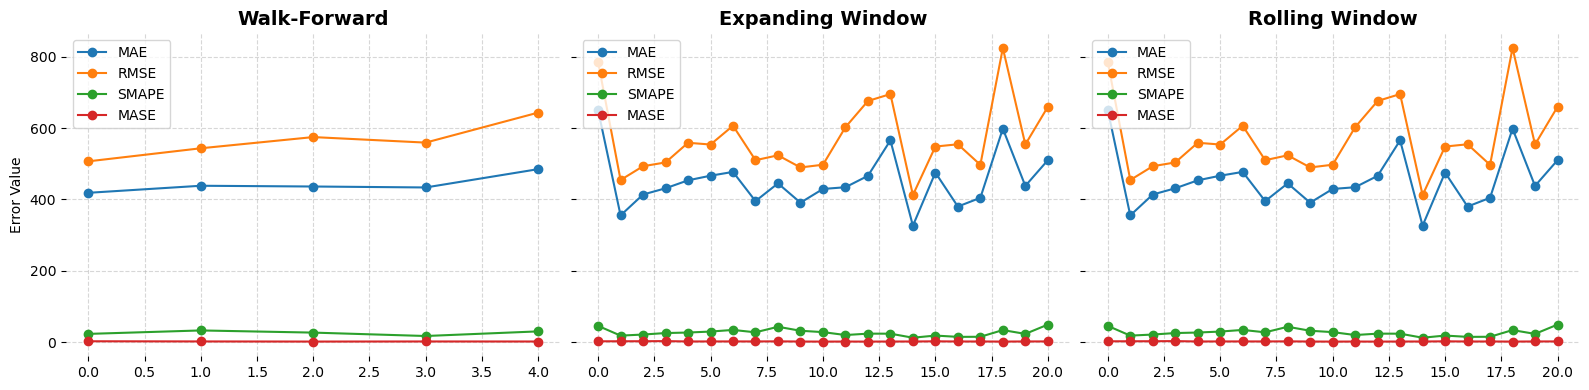

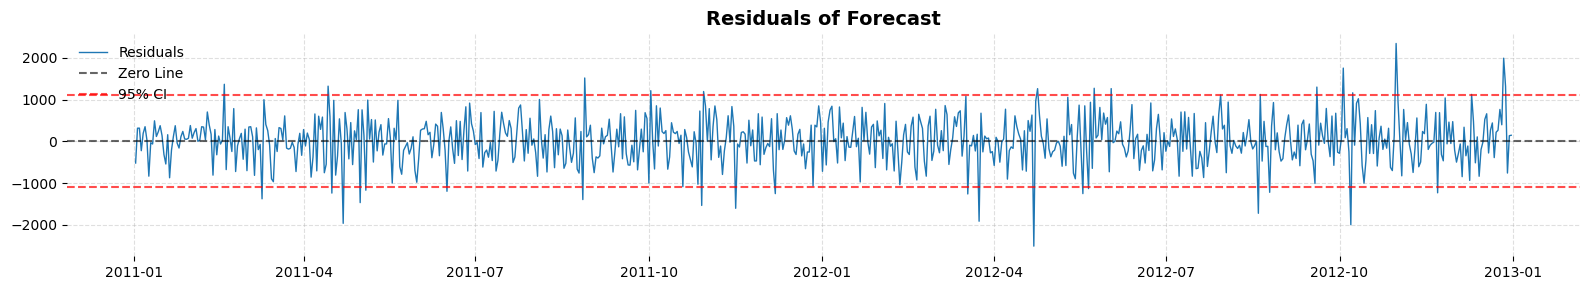

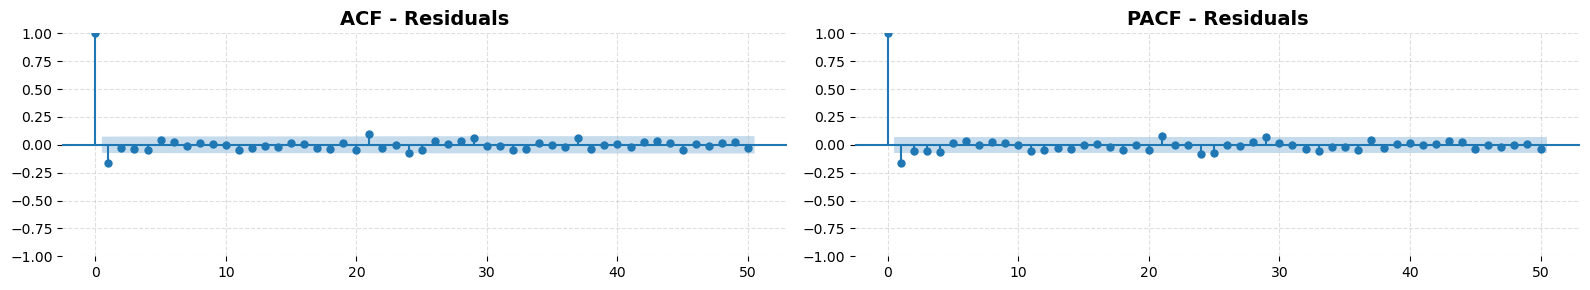

,Model,Baseline,Improvement
MAE,436.312071,278.586325,-56.616471
RMSE,563.895389,407.237227,-38.468527
SMAPE,29.138631,18.14243,-60.610408
MASE,1.566165,1.0,-56.616471
DM Test p-value,,,6.289566117367546e-37
Statistical Significance,,,Significant


In [37]:
random_walk_drift = True if is_trend_present else False
random_walk_forecast_df = base_forecast.random_walk_forecast(transformed_df, forecast_column, steps=60, drift=random_walk_drift)
random_walk_forecast_metrics, random_walk_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=random_walk_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'random_walk_forecast')

#### EXPONENTIAL SMOOTHING

In [51]:
def exponential_smoothing_forecast(transformed_df, forecast_column, steps=60):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    ts = df[forecast_column]
    model = SimpleExpSmoothing(ts, initialization_method="estimated").fit()

    fitted_values = model.fittedvalues
    df['exponential_smoothing_forecast'] = fitted_values
    df.iloc[0, df.columns.get_loc('exponential_smoothing_forecast')] = float('nan')

    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]

    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [pd.NA] * steps,
        'exponential_smoothing_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })

    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = pd.NA

    cols = list(transformed_df.columns) + ['exponential_smoothing_forecast', 'is_future_forecast']
    future_df = future_df[cols]
    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df


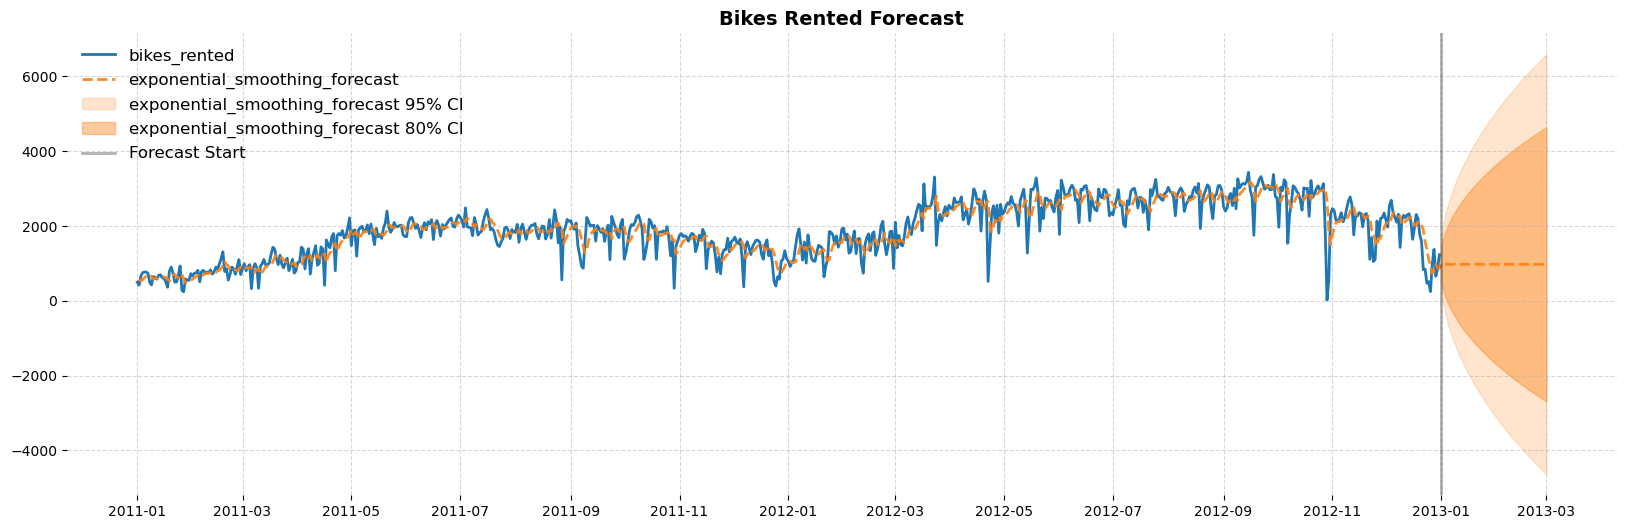

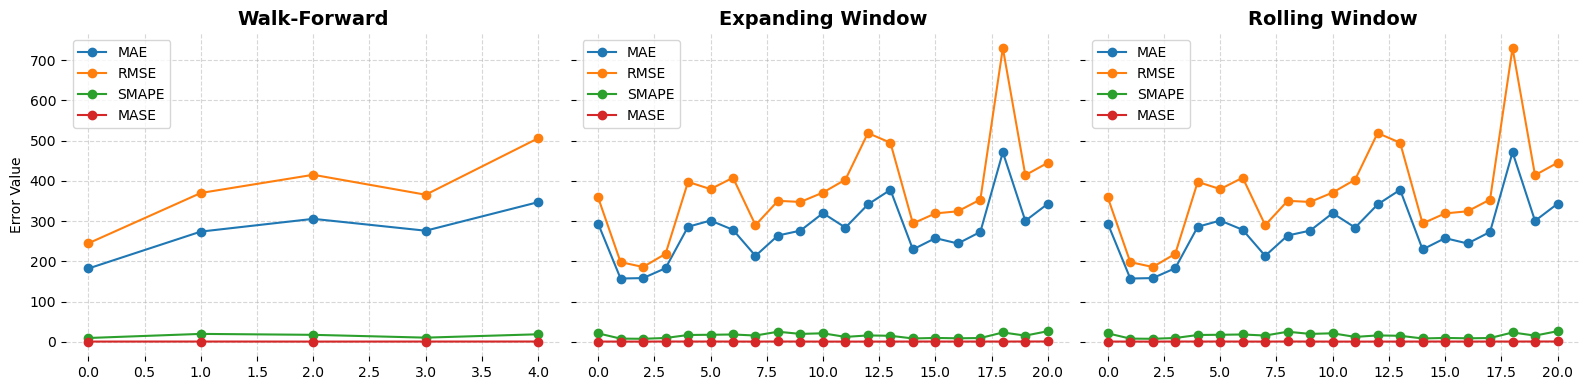

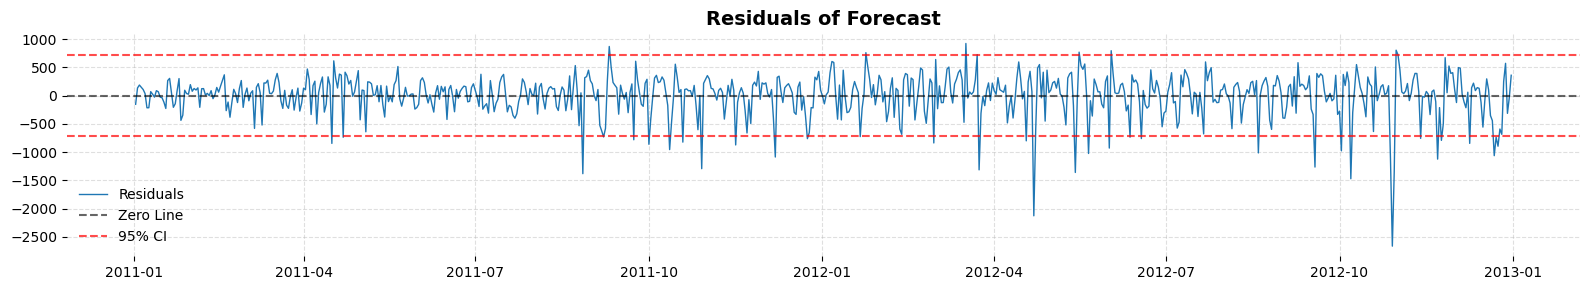

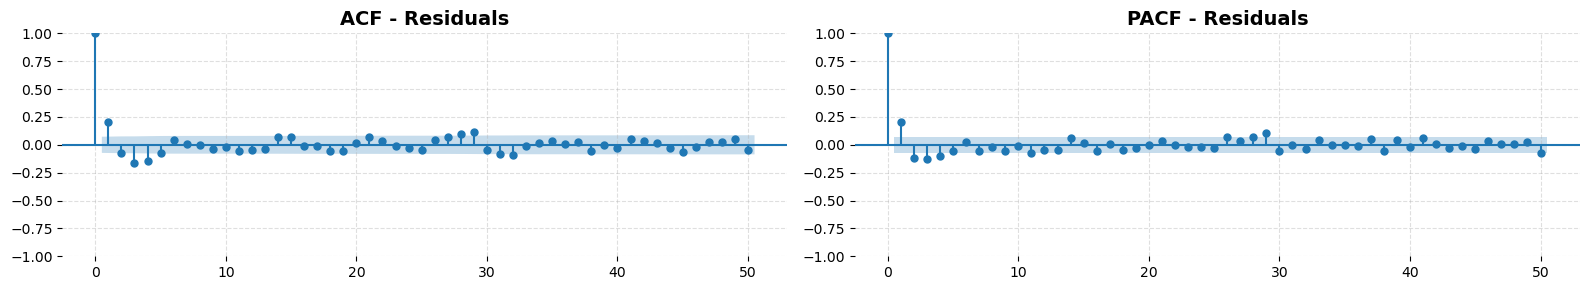

,Model,Baseline,Improvement
MAE,263.311504,278.586325,5.482976
RMSE,369.551552,407.237227,9.253986
SMAPE,16.465381,18.14243,9.243794
MASE,0.94517,1.0,5.482976
DM Test p-value,,,0.057198722306048895
Statistical Significance,,,Not Significant


In [52]:
exponential_smoothing_forecast_df = exponential_smoothing_forecast(transformed_df, forecast_column, steps=60)
exponential_smoothing_forecast_metrics, exponential_smoothing_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=exponential_smoothing_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'exponential_smoothing_forecast')

#### HOLT

In [58]:
from statsmodels.tsa.holtwinters import Holt

def holt_forecast(transformed_df, forecast_column, steps=60):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    ts = df[forecast_column]
    model = Holt(ts, initialization_method="estimated").fit()

    fitted_values = model.fittedvalues
    df['holt_forecast'] = fitted_values
    df.iloc[0, df.columns.get_loc('holt_forecast')] = float('nan')

    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]

    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [pd.NA] * steps,
        'holt_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })

    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = pd.NA

    cols = list(transformed_df.columns) + ['holt_forecast', 'is_future_forecast']
    future_df = future_df[cols]

    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df

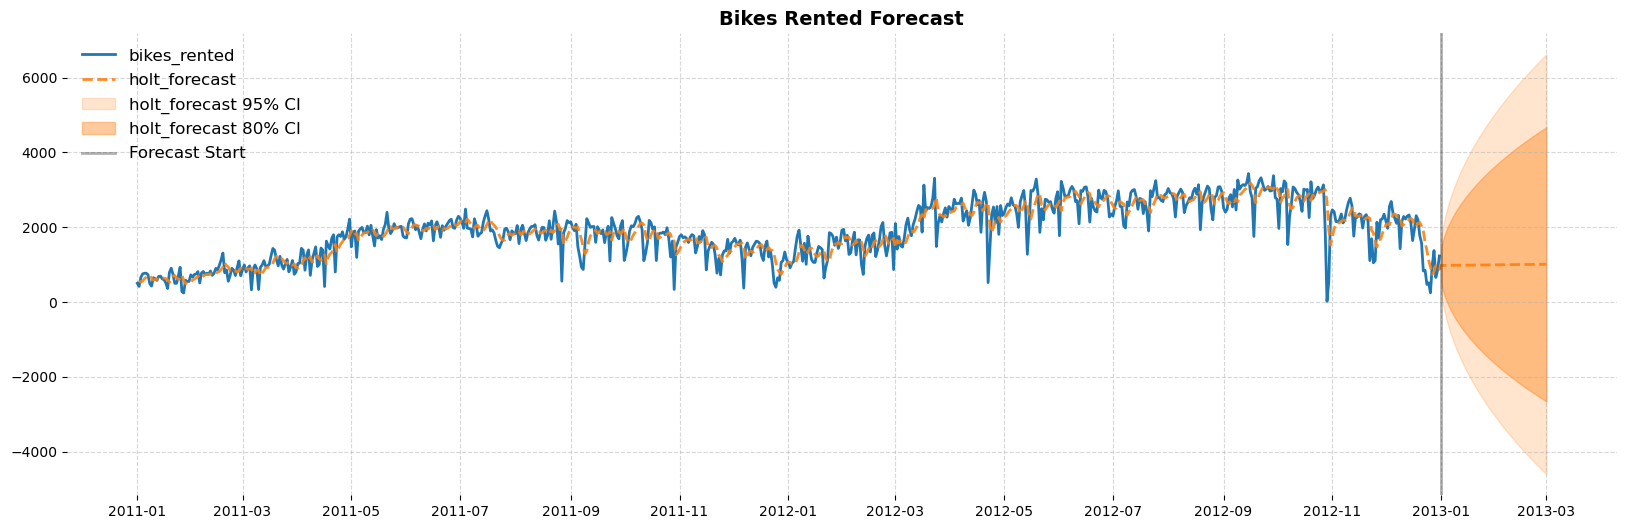

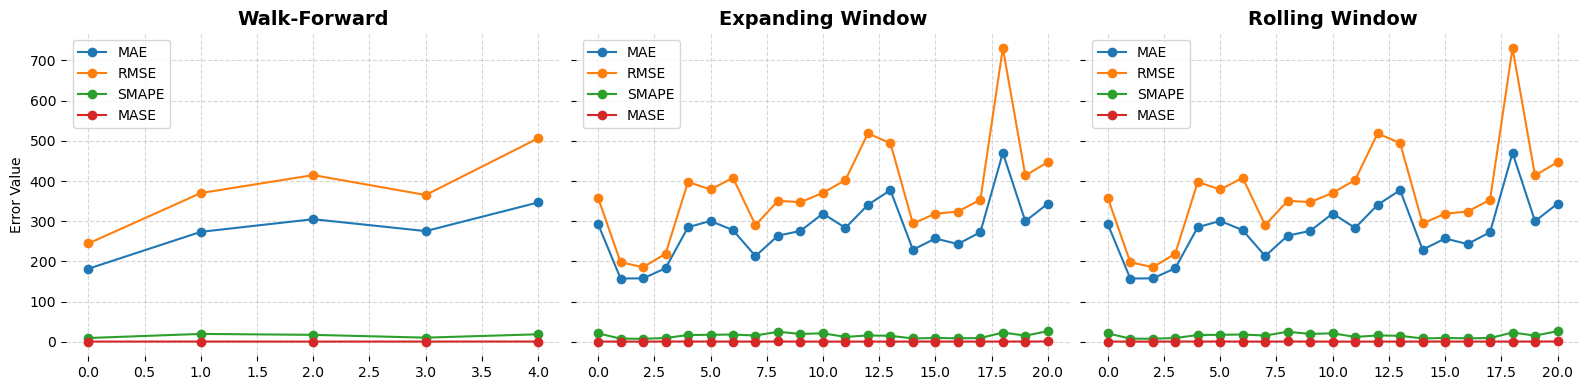

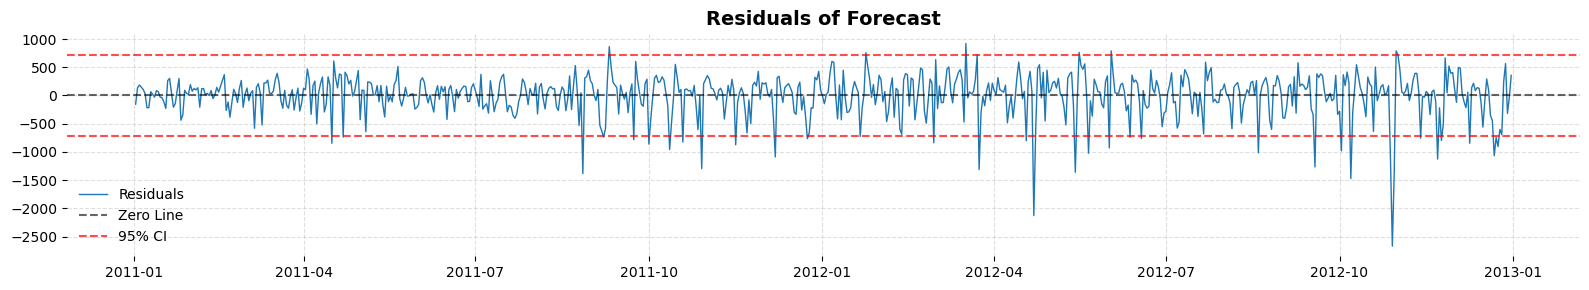

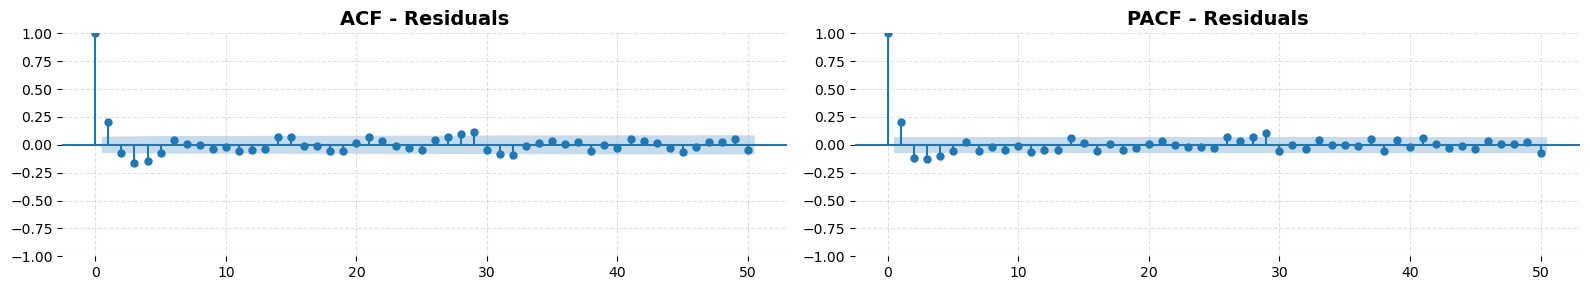

,Model,Baseline,Improvement
MAE,262.832603,278.586325,5.65488
RMSE,369.569043,407.237227,9.249691
SMAPE,16.428773,18.14243,9.445579
MASE,0.943451,1.0,5.65488
DM Test p-value,,,0.05070864989343877
Statistical Significance,,,Not Significant


In [59]:
holt_forecast_df = holt_forecast(transformed_df, forecast_column, steps=60)
holt_forecast_metrics, holt_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=holt_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'holt_forecast')

#### HOLT-WINTERS

In [74]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holt_winters_forecast(transformed_df, forecast_column, seasonal='add', trend='add', seasonal_periods= 365, steps=60):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    
    ts = df[forecast_column]
    model = ExponentialSmoothing(ts, seasonal='add', trend='add', seasonal_periods= 365, initialization_method="estimated").fit()
    fitted_values = model.fittedvalues
    df['holt_winters_forecast'] = fitted_values
    df.iloc[0, df.columns.get_loc('holt_winters_forecast')] = float('nan')
    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]
    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [pd.NA] * steps,
        'holt_winters_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })
    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = pd.NA

    cols = list(transformed_df.columns) + ['holt_winters_forecast', 'is_future_forecast']
    future_df = future_df[cols]
    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df


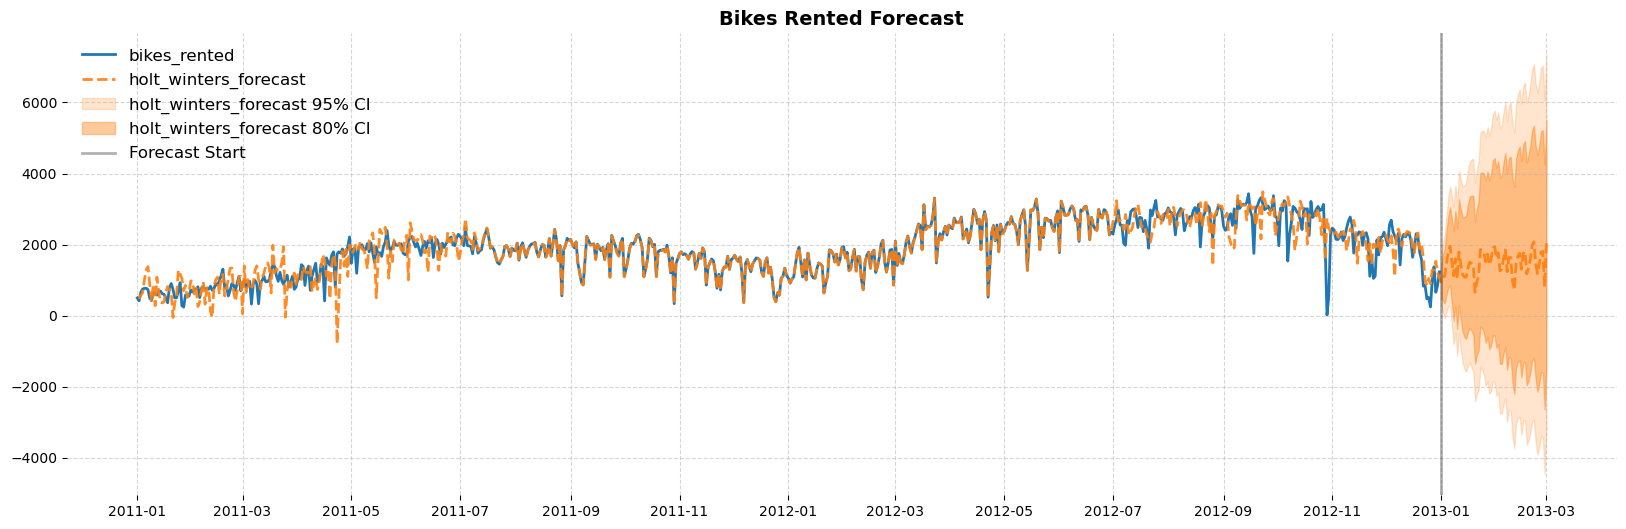

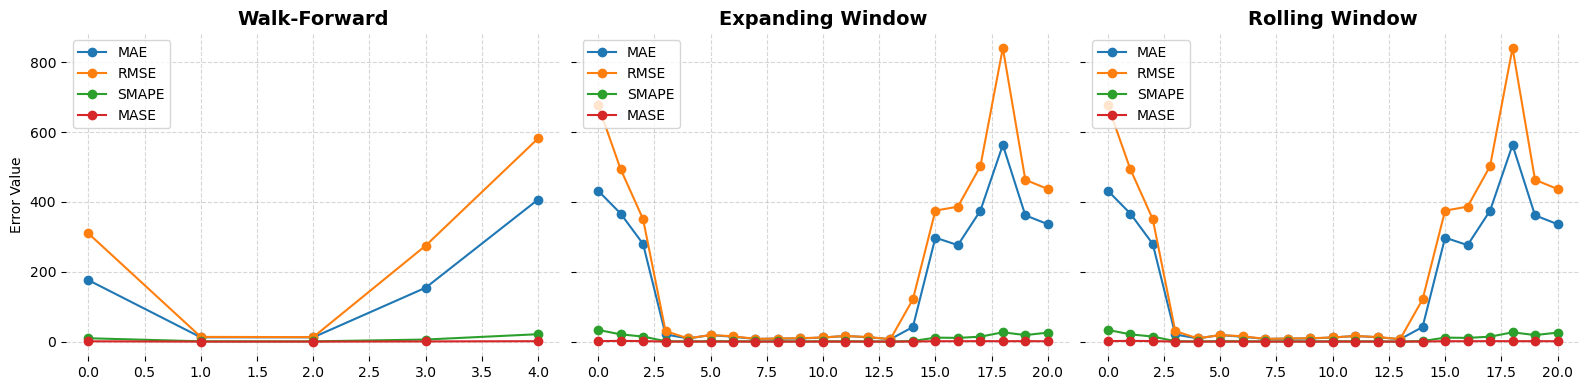

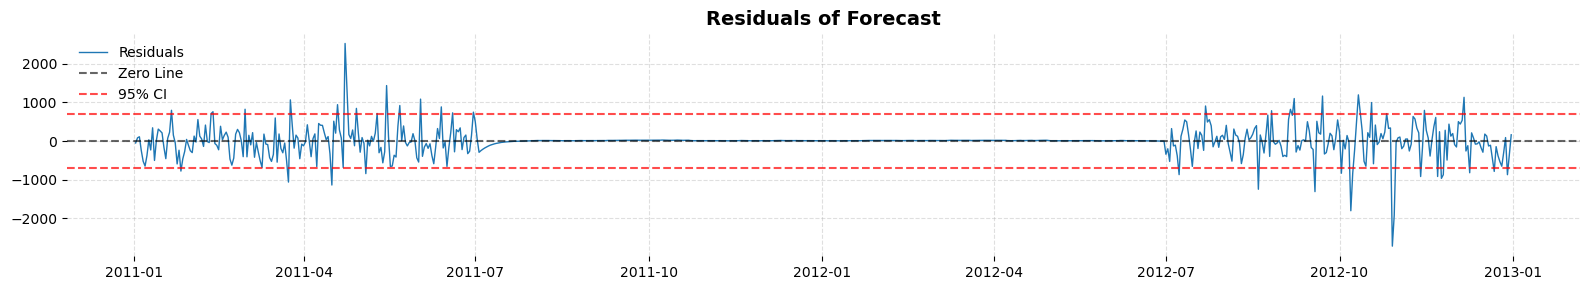

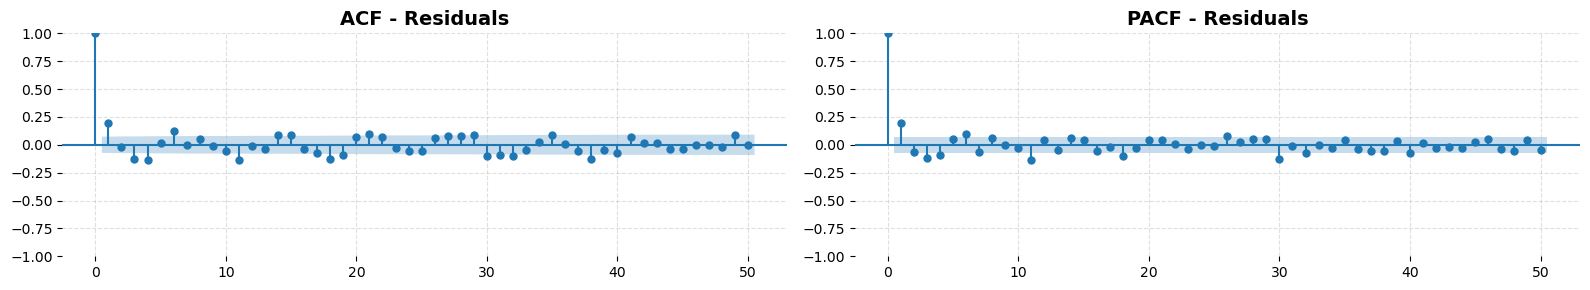

,Model,Baseline,Improvement
MAE,183.335242,278.586325,34.190868
RMSE,350.226309,407.237227,13.999437
SMAPE,13.125186,18.14243,27.654751
MASE,0.658091,1.0,34.190868
DM Test p-value,,,2.324881413791137e-11
Statistical Significance,,,Significant


In [75]:
holt_winters_forecast_df = holt_winters_forecast(transformed_df, forecast_column, steps=60)
holt_winters_forecast_metrics, holt_winters_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=holt_winters_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'holt_winters_forecast')

#### MOVING AVERAGE

In [ ]:
holt_winters_forecast_df = holt_winters_forecast(transformed_df, forecast_column, steps=60)
holt_winters_forecast_metrics, holt_winters_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=holt_winters_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'holt_winters_forecast')

### STATISTICAL FORECASTING

## MULTIVARIANT FORECASTING

### STATISTICAL FORECAST FEATURE ENGINEERING

### STATISTICAL FORECASTING

#### SARIMAX

#### VAR

#### VECM

### ML FORECAST FEATURE ENGINEERING

#### COMPLETE CORRELATION AND COLLINEARITY

In [ ]:
plt.figure(figsize=(20, 16))
df_encoded_to_corr = pd.get_dummies(df.drop(columns=[target_column, "date"], errors="ignore"), drop_first=True)
df_corr = df_encoded_to_corr.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between all variables")
plt.show()

### ML FORECASTING

#### XGBOOST

#### LIGHTGMB